# Predicting NYC Taxi Fares with RAPIDS

[RAPIDS](https://rapids.ai/) is a suite of GPU accelerated data science libraries with APIs that should be familiar to users of Pandas, Dask, and Scikitlearn.

Anaconda has graciously made some of the NYC Taxi dataset available in [a public Google Cloud Storage bucket](https://console.cloud.google.com/storage/browser/anaconda-public-data/nyc-taxi/csv/).

This notebook builds a simple data pipeline to load the data with cuDF (or Pandas), analyze it with cuML (or scikit-learn), and then try some steps with multiple GPUs.

In [1]:
import os
import requests
from tqdm.auto import tqdm

def download(url, fname):
    response = requests.get(url, stream=True)
    with tqdm.wrapattr(
        open(fname, "wb"), "write",
        unit='B', unit_scale=True, unit_divisor=1024, miniters=1,
        desc=fname, total=int(response.headers.get('content-length', 0))
    ) as fout:
        for chunk in response.iter_content(chunk_size=4096):
            fout.write(chunk)

base = "https://d37ci6vzurychx.cloudfront.net/trip-data/"
for i in range(1, 13):
    fname = f"yellow_tripdata_2021-{i:02d}.parquet"
    if not os.path.exists(fname):
        download(base + fname, fname)

yellow_tripdata_2021-01.parquet:   0%|          | 0.00/20.7M [00:00<?, ?B/s]

yellow_tripdata_2021-02.parquet:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

yellow_tripdata_2021-03.parquet:   0%|          | 0.00/28.6M [00:00<?, ?B/s]

yellow_tripdata_2021-04.parquet:   0%|          | 0.00/32.4M [00:00<?, ?B/s]

yellow_tripdata_2021-05.parquet:   0%|          | 0.00/36.9M [00:00<?, ?B/s]

yellow_tripdata_2021-06.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

yellow_tripdata_2021-07.parquet:   0%|          | 0.00/41.7M [00:00<?, ?B/s]

yellow_tripdata_2021-08.parquet:   0%|          | 0.00/41.4M [00:00<?, ?B/s]

yellow_tripdata_2021-09.parquet:   0%|          | 0.00/44.0M [00:00<?, ?B/s]

yellow_tripdata_2021-10.parquet:   0%|          | 0.00/50.8M [00:00<?, ?B/s]

yellow_tripdata_2021-11.parquet:   0%|          | 0.00/50.6M [00:00<?, ?B/s]

yellow_tripdata_2021-12.parquet:   0%|          | 0.00/47.3M [00:00<?, ?B/s]

In [2]:
import numpy as np
import pandas as pd
# import cuml
import cudf
import os

# Inspecting the Data

Let's start with a familiar Pandas approach then port it to RAPIDS in parallel

In [3]:
# FIXME
base_path = ''

In [4]:
%%time
# Pandas

df_2021 = pd.read_parquet(base_path+'yellow_tripdata_2021-01.parquet')
df_2021.head()

CPU times: user 699 ms, sys: 687 ms, total: 1.39 s
Wall time: 176 ms


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.0,3.0,0.5,0.00,0.0,0.3,11.80,2.5,NaN
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0,NaN
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.0,0.5,0.5,8.65,0.0,0.3,51.95,0.0,NaN
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.0,0.5,0.5,6.05,0.0,0.3,36.35,0.0,NaN
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.5,0.5,0.5,4.06,0.0,0.3,24.36,2.5,NaN


In [92]:
%%time
# TODO: Read the CSV with cudf into gdf_2021

gdf_2021 = cudf.read_parquet(base_path+'yellow_tripdata_2021-01.parquet')
gdf_2021.head()

CPU times: user 238 ms, sys: 3.88 ms, total: 242 ms
Wall time: 235 ms


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.0,3.0,0.5,0.00,0.0,0.3,11.80,2.5,<NA>
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0,<NA>
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.0,0.5,0.5,8.65,0.0,0.3,51.95,0.0,<NA>
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.0,0.5,0.5,6.05,0.0,0.3,36.35,0.0,<NA>
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.5,0.5,0.5,4.06,0.0,0.3,24.36,2.5,<NA>


# Data Cleanup

As usual, the data needs to be massaged a bit before we can start adding features that are useful to an ML model.

For example, in the 2014 taxi CSV files, there are `pickup_datetime` and `dropoff_datetime` columns.

Also, some CSV files have column names with extraneous spaces in them.

We'll do a little string manipulation, column renaming, and concatenating of DataFrames to sidestep the problems.

In [ ]:
## Do we need the re-typing? I guess for float64?
## TODO: do we need a utility function, cudf.float64_to_float32?
## Should we use rename(dict, axis=1)

In [197]:
# list of column names that need to be re-mapped
remap = {
    'tpep_pickup_datetime': 'pickup_datetime',
    'tpep_dropoff_datetime': 'dropoff_datetime',
    'ratecodeid': 'rate_code',
    'pulocationid': 'pickup_location',
    'dolocationid': 'dropoff_location'
}

# create a list of columns & dtypes the df must have
# note that float64 will be significantly slower on some GPUs (most GeForce, also Tesla T4)
must_haves = {
    'pickup_datetime': 'datetime64[ms]',
    'dropoff_datetime': 'datetime64[ms]',
    'passenger_count': 'int32',
    'trip_distance': 'float',
    'pickup_longitude': 'float',
    'pickup_latitude': 'float',
    'rate_code': 'int32',
    'dropoff_longitude': 'float',
    'dropoff_latitude': 'float',
    'fare_amount': 'float',
    'pickup_location': 'int32',
    'dropoff_location': 'int32',
    'is_credit_card': 'int32',
    'airport_fee': 'float32',
   # 'tip_amount': 'float32'
}

In [198]:
# helper function which takes a DataFrame and fixes column types
def clean_columns(df_part, remap, must_haves):
    ## Build extra features we need
    df_part["is_credit_card"] = df_part["payment_type"] == 1

    # iterate through columns in this df
    for col in df_part.columns:
        # drop anything not in our expected list
        if col not in must_haves:
            print(f"Dropping ({col})")
            df_part = df_part.drop(columns=col)
            continue
        if df_part[col].dtype.kind in {'i', 'f'}:
            df_part[col] = df_part[col].fillna(-1)
        df_part[col] = df_part[col].astype(must_haves[col])
        
    return df_part

In [199]:
## Maybe this one doesn't need the pandas approach since it's straightforward?

In [200]:
%%time
# Pandas approach

# some col-names include pre-pended spaces remove & lowercase column names
col_cleanup = {col: col.strip().lower() for col in list(df_2021.columns)}
df = df_2021.rename(columns=col_cleanup)
# rename columns using the supplied mapping
df = df.rename(remap, axis=1)

df = clean_columns(df, remap, must_haves)
print(df.__class__)
df.head()

Dropping (vendorid)
Dropping (store_and_fwd_flag)
Dropping (payment_type)
Dropping (extra)
Dropping (mta_tax)
Dropping (tip_amount)
Dropping (tolls_amount)
Dropping (improvement_surcharge)
Dropping (total_amount)
Dropping (congestion_surcharge)
<class 'pandas.core.frame.DataFrame'>
CPU times: user 1.38 s, sys: 0 ns, total: 1.38 s
Wall time: 1.35 s


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1,2.10,1,142,43,8.0,-1.0,0
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1,0.20,1,238,151,3.0,-1.0,0
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1,14.70,1,132,165,42.0,-1.0,1
3,2021-01-01 00:15:48,2021-01-01 00:31:01,0,10.60,1,138,132,29.0,-1.0,1
4,2021-01-01 00:31:49,2021-01-01 00:48:21,1,4.94,1,68,33,16.5,-1.0,1


In [201]:
## Don't drop payment_type, tip_amount, or airport_fee

In [202]:
%%time
# TODO: RAPIDS approach - same as aPandas, but generate 'gdf' as output
# some col-names include pre-pended spaces remove & lowercase column names
col_cleanup = {col: col.strip().lower() for col in list(gdf_2021.columns)}
gdf = gdf_2021.rename(columns=col_cleanup)
# rename columns using the supplied mapping
gdf = gdf.rename(remap, axis=1)

gdf = clean_columns(gdf, remap, must_haves)
print(gdf.__class__)
gdf.head()

Dropping (vendorid)
Dropping (store_and_fwd_flag)
Dropping (payment_type)
Dropping (extra)
Dropping (mta_tax)
Dropping (tip_amount)
Dropping (tolls_amount)
Dropping (improvement_surcharge)
Dropping (total_amount)
Dropping (congestion_surcharge)
<class 'cudf.core.dataframe.DataFrame'>
CPU times: user 128 ms, sys: 0 ns, total: 128 ms
Wall time: 126 ms


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1,2.10,1,142,43,8.0,-1.0,0
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1,0.20,1,238,151,3.0,-1.0,0
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1,14.70,1,132,165,42.0,-1.0,1
3,2021-01-01 00:15:48,2021-01-01 00:31:01,0,10.60,1,138,132,29.0,-1.0,1
4,2021-01-01 00:31:49,2021-01-01 00:48:21,1,4.94,1,68,33,16.5,-1.0,1


# Look at some key stats

In [203]:
import seaborn as sns

<Axes: xlabel='passenger_count', ylabel='fare_amount'>

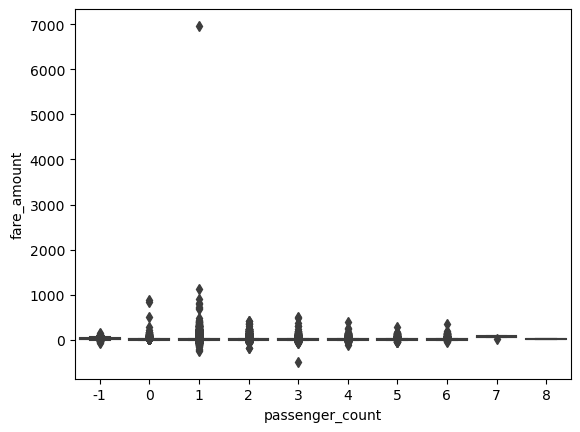

In [204]:
sns.boxplot(x="passenger_count", y="fare_amount", data=df)

# Filter the data

In [205]:
%%time

# apply a list of filter conditions to throw out records with missing or outlier values
query_frags = [
    'fare_amount > 0 and fare_amount < 500',
    'passenger_count > 0 and passenger_count < 6',
]
df_subset = df.query(' and '.join(query_frags)).copy()

# inspect the results of cleaning
df_subset.head()

CPU times: user 129 ms, sys: 0 ns, total: 129 ms
Wall time: 126 ms


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1,2.10,1,142,43,8.0,-1.0,0
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1,0.20,1,238,151,3.0,-1.0,0
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1,14.70,1,132,165,42.0,-1.0,1
4,2021-01-01 00:31:49,2021-01-01 00:48:21,1,4.94,1,68,33,16.5,-1.0,1
5,2021-01-01 00:16:29,2021-01-01 00:24:30,1,1.60,1,224,68,8.0,-1.0,1


In [206]:
%%time

# TODO: RAPIDS version with "gdf_subset" as output

# apply a list of filter conditions to throw out records with missing or outlier values
query_frags = [
    'fare_amount > 0 and fare_amount < 500',
    'passenger_count > 0 and passenger_count < 6',
]
gdf_subset = gdf.query(' and '.join(query_frags)).copy()

# inspect the results of cleaning
gdf_subset.head()

CPU times: user 12.3 ms, sys: 0 ns, total: 12.3 ms
Wall time: 9.8 ms


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1,2.10,1,142,43,8.0,-1.0,0
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1,0.20,1,238,151,3.0,-1.0,0
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1,14.70,1,132,165,42.0,-1.0,1
4,2021-01-01 00:31:49,2021-01-01 00:48:21,1,4.94,1,68,33,16.5,-1.0,1
5,2021-01-01 00:16:29,2021-01-01 00:24:30,1,1.60,1,224,68,8.0,-1.0,1


# Demo 3: UDFs to add rich features 

cuDF provides standard DataFrame operations, but also let you run "user defined functions" on the underlying data.

cuDF's [apply_rows](https://rapidsai.github.io/projects/cudf/en/0.6.0/api.html#cudf.dataframe.DataFrame.apply_rows) operation is similar to Pandas's [DataFrame.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html), except that for cuDF, custom Python code is [JIT compiled by numba](https://numba.pydata.org/numba-doc/dev/cuda/kernels.html) into GPU kernels.

We'll use a Haversine Distance calculation to find total trip distance, and extract additional useful variables from the datetime fields.

In [207]:
from numpy import pi

# FIXME: Add a feature via UDF

def add_features(df):
    df['hour'] = df['pickup_datetime'].dt.hour
    df['year'] = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day'] = df['pickup_datetime'].dt.day
    
    df["day_of_week"] = df["pickup_datetime"].dt.dayofweek
    
    df = df.drop(columns=['pickup_datetime', 'dropoff_datetime'])    
    
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(np.int32)
    return df

In [208]:
%%time

# actually add the features
taxi_df = add_features(df_subset)
taxi_df

CPU times: user 471 ms, sys: 0 ns, total: 471 ms
Wall time: 464 ms


,passenger_count,trip_distance,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card,hour,year,month,day,day_of_week,is_weekend
0,1,2.10,1,142,43,8.0,-1.0,0,0,2021,1,1,4,0
1,1,0.20,1,238,151,3.0,-1.0,0,0,2021,1,1,4,0
2,1,14.70,1,132,165,42.0,-1.0,1,0,2021,1,1,4,0
4,1,4.94,1,68,33,16.5,-1.0,1,0,2021,1,1,4,0
5,1,1.60,1,224,68,8.0,-1.0,1,0,2021,1,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271412,3,0.81,1,41,74,5.0,-1.0,0,23,2021,1,31,6,1
1271413,1,3.81,1,113,141,12.5,-1.0,0,23,2021,1,31,6,1
1271414,1,1.32,1,233,237,6.0,-1.0,0,23,2021,1,31,6,1
1271415,2,10.56,1,56,68,37.5,-1.0,1,23,2021,1,31,6,1


## cuDF version with UDF

cuDF's [apply_rows](https://rapidsai.github.io/projects/cudf/en/0.6.0/api.html#cudf.dataframe.DataFrame.apply_rows) operation is similar to Pandas's [DataFrame.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html), except that for cuDF, custom Python code is [JIT compiled by numba](https://numba.pydata.org/numba-doc/dev/cuda/kernels.html) into GPU kernels.

In [209]:
%%time

# TODO: actually add the features and create "taxi_gdf" from gdf_subset
taxi_gdf = add_features(gdf_subset)
taxi_gdf

CPU times: user 8.37 ms, sys: 0 ns, total: 8.37 ms
Wall time: 6.94 ms


,passenger_count,trip_distance,rate_code,pickup_location,dropoff_location,fare_amount,airport_fee,is_credit_card,hour,year,month,day,day_of_week,is_weekend
0,1,2.10,1,142,43,8.0,-1.0,0,0,2021,1,1,4,0
1,1,0.20,1,238,151,3.0,-1.0,0,0,2021,1,1,4,0
2,1,14.70,1,132,165,42.0,-1.0,1,0,2021,1,1,4,0
4,1,4.94,1,68,33,16.5,-1.0,1,0,2021,1,1,4,0
5,1,1.60,1,224,68,8.0,-1.0,1,0,2021,1,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271412,3,0.81,1,41,74,5.0,-1.0,0,23,2021,1,31,6,1
1271413,1,3.81,1,113,141,12.5,-1.0,0,23,2021,1,31,6,1
1271414,1,1.32,1,233,237,6.0,-1.0,0,23,2021,1,31,6,1
1271415,2,10.56,1,56,68,37.5,-1.0,1,23,2021,1,31,6,1


For more advanced spatial calculations, check out cuSpatial (https://medium.com/rapids-ai/releasing-cuspatial-to-accelerate-geospatial-and-spatiotemporal-processing-b686d8b32a9), the newest RAPIDS library.

In [210]:
# TODO: Print summary stats from "taxi_gdf"

# Pick a Training Set

Let's imagine you're a taxi operator trying to understand consumer tipping behavior. We have tip amounts and lots of financial features in the data. Let's start by splitting into a training set and a test set so we'll be able to see how well we do.


In [ ]:
%%time

y_df = taxi_df["is_credit_card"]
X_df = taxi_df.drop(columns="is_credit_card")

# Split our dataframes
X_train_df, X_test_df, y_train_df, y_test_df = sklearn.model_selection.train_test_split(X_df, y_df)

# Create array versions of these dataframes
X_train_np, X_test_np = (X_train_df.to_numpy(np.float32), X_test_df.to_numpy(np.float32))
y_train_np, y_test_np = (y_train_df.to_numpy(np.float32), y_test_df.to_numpy(np.float32))

len(X_train_df)

CPU times: user 488 ms, sys: 0 ns, total: 488 ms
Wall time: 479 ms


909117

In [ ]:
## TODO: keep a lot more minor features, like fees and charge type
## TODO: Mabe predict 

In [ ]:
%%time

y_gdf = taxi_gdf["is_credit_card"]
X_gdf = taxi_gdf.drop(columns="is_credit_card")

# Split our dataframes
X_train_gdf, X_test_gdf, y_train_gdf, y_test_gdf = sklearn.model_selection.train_test_split(X_gdf, y_gdf)

# Create array versions of these dataframes
X_train_gpu, X_test_gpu = (X_train_gdf.to_cupy(np.float32), X_test_gdf.to_cupy(np.float32))
y_train_gpu, y_test_gpu = (y_train_gdf.to_cupy(np.float32), y_test_gdf.to_cupy(np.float32))

len(X_train_gdf)

CPU times: user 50.9 ms, sys: 0 ns, total: 50.9 ms
Wall time: 49.8 ms


909117

# Demo 4: Cluster and analyze with cuML

Let's start by getting a feel for our data with some unsupervised learn. Are there clear clusters of trip types that stand out?

In [214]:
%matplotlib inline

In [215]:
import sklearn, sklearn.cluster
from matplotlib import pyplot as plt

In [216]:
%%time
## Maybe drop the CPU section here? It's 10x to 20x faster than CPU but both are reasonably fast
# use scikit-learn on CPU

# sk_kmeans = sklearn.cluster.KMeans(n_clusters=5)
#train_clusters_cpu = sk_kmeans.fit_predict(X_train_np)

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 20.3 µs


In [217]:
%%time

# TODO: use cuML on GPU to fit KMeans with 5 clusters
cu_kmeans = cuml.cluster.KMeans(n_clusters=5)
train_clusters_gpu = cu_kmeans.fit_predict(X_train_np)

CPU times: user 150 ms, sys: 0 ns, total: 150 ms
Wall time: 146 ms


In [218]:
# Just take a subset to speed plotting
num_to_plot = 100000

gdf_plot = X_train_gdf.iloc[:num_to_plot]
gdf_plot["cluster"] = train_clusters_gpu[:num_to_plot]
gdf_plot["tip_amount"] = y_train_gdf.iloc[:num_to_plot]
gdf_plot["short_trip"] = gdf_train_head["trip_distance"] < 1.01 # About the 25th percentile
gdf_plot["is_rush_est"] = ((gdf_train_head.hour >= 10) & (gdf_train_head.hour <= 14)) | \
                                ((gdf_train_head.hour >= 21) & (gdf_train_head.hour <= 24))

## TODO: switch to latlon x/y
# actually do the plot
sns.lmplot(data=gdf_plot.to_pandas(),
           x="fare_amount", y="tip_amount",
           hue="cluster", col="is_credit_card", fit_reg=False, scatter_kws={"s": 10})

KeyError: "['is_credit_card'] not in index"

### Fit a simple supervised model with cuML

cuML supports a large range of supervised models, all emulating the scikit-learn interfaces. See the README (https://github.com/rapidsai/cuml) for a recent list. Here, we'll try a very common but powerful model - a random forest ensemble for classification.

In [221]:
from sklearn.linear_model import ElasticNet as skElastic
from cuml.linear_model import ElasticNet as cuElastic

from sklearn.ensemble import RandomForestClassifier as skRandomForestClassifier
from cuml.ensemble import RandomForestClassifier as cuRandomForestClassifier

In [226]:
%%time
# Sklearn will parallelize over all CPU cores with n_jobs=-1
sk_model = skRandomForestClassifier(n_estimators=250, n_jobs=-1)
sk_model.fit(X_train_np, y_train_np)

CPU times: user 13min 14s, sys: 3.31 s, total: 13min 18s
Wall time: 37.4 s


RandomForestClassifier(n_estimators=250, n_jobs=-1)

In [227]:
%%time

# TODO: Build a similar model on GPU with cuML

cuml_model = cuRandomForestClassifier(n_estimators=250)
cuml_model.fit(X_train_gpu, y_train_gpu)

CPU times: user 20.6 s, sys: 245 ms, total: 20.8 s
Wall time: 7.25 s


RandomForestClassifier()

Accuracy:  0.7478344440460205
AUC:  0.647713840007782
CPU times: user 8.85 s, sys: 0 ns, total: 8.85 s
Wall time: 1.94 s


<Axes: ylabel='Density'>

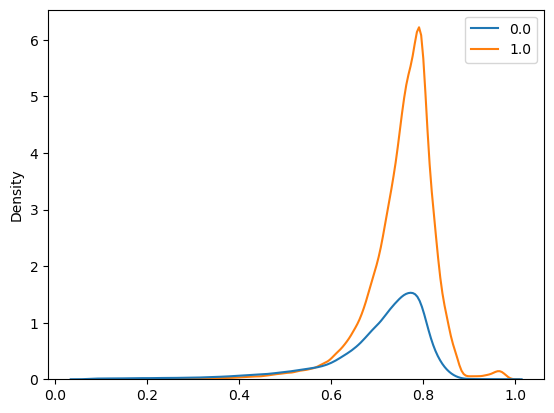

In [225]:
%%time

# TODO: Predict on a test set (storing as "rf_predictions" in the Y_test_gdf df)
# and evaluate the predictions' R2 score
rf_predictions = cuml_model.predict(X_test_gpu)
rf_probabilities = cuml_model.predict_proba(X_test_gpu)[:,1]

#print("RMSE: ", cuml.metrics.regression.mean_squared_error(y_test_gpu, rf_predictions, squared=False))
print("Accuracy: ", cuml.metrics.accuracy.accuracy_score(y_test_gpu, rf_predictions))
print("AUC: ", cuml.metrics.roc_auc_score(y_test_gpu, rf_probabilities))

sns.kdeplot(x=rf_probabilities.get(), hue=y_test_gpu.get())